In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

# Set device
device = "cuda:2"

### 1. Diffusion Scheduler ###
# ----------------------------
# Manages the noise schedule and the forward (noising) process.

def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

# --- Forward Process (q) ---
def forward_diffusion_sample(x_0, t, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod):
    """
    Takes an image and a timestep and returns the noisy version of the image.
    This is based on the formula: x_t = sqrt(alpha_bar_t) * x_0 + sqrt(1 - alpha_bar_t) * N(0, I)
    """
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(sqrt_one_minus_alphas_cumprod, t, x_0.shape)
    mean = sqrt_alphas_cumprod_t * x_0
    variance = sqrt_one_minus_alphas_cumprod_t * noise
    return mean + variance

/raid/home/chandanj/miniconda3/envs/raghava/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
### 2. U-Net Model Architecture (Identical to noise-prediction version) ###
# ---------------------------------
# The U-Net architecture remains the same. Its task is just different:
# predict a mean vector (same shape as image) instead of a noise vector.

class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_ch)
        self.bn2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()
        
    def forward(self, x, t, ):
        h = self.bn1(self.relu(self.conv1(x)))
        time_emb = self.relu(self.time_mlp(t))
        time_emb = time_emb[(..., ) + (None, ) * 2]
        h = h + time_emb
        h = self.bn2(self.relu(self.conv2(h)))
        return self.transform(h)

class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

In [3]:
class SimpleUnet(nn.Module):
    def __init__(self):
        super().__init__()
        image_channels = 1
        down_channels = (64, 128, 256)
        up_channels = (256, 128, 64)
        out_dim = 1 
        time_emb_dim = 32

        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], time_emb_dim) for i in range(len(down_channels)-1)])
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], time_emb_dim, up=True) for i in range(len(up_channels)-1)])
        # The output of the model is now the predicted mean, which has the same dimension as the input image.
        self.output = nn.Conv2d(up_channels[-1], image_channels, 1)

    def forward(self, x, timestep):
        t = self.time_mlp(timestep)
        x = self.conv0(x)
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            x = torch.cat((x, residual_x), dim=1)           
            x = up(x, t)
        return self.output(x)

In [4]:
### 3. Training ###
# -----------------
# We train the U-Net model to predict the mean of the posterior q(x_{t-1} | x_t, x_0).

# Hyperparameters
IMG_SIZE = 28
BATCH_SIZE = 128
EPOCHS = 100
LR = 0.001
TIMESTEPS = 1000

# --- Prepare Diffusion Schedule Constants ---
betas = linear_beta_schedule(timesteps=TIMESTEPS)
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)

sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

# ** NEW **: Coefficients for the posterior mean q(x_{t-1} | x_t, x_0)
# This is the "ground truth" mean that our model will learn to predict.
# Formula: \tilde{\mu}_t(x_t, x_0) = \frac{\sqrt{\bar{\alpha}_{t-1}}\beta_t}{1-\bar{\alpha}_t}x_0 + \frac{\sqrt{\alpha_t}(1-\bar{\alpha}_{t-1})}{1-\bar{\alpha}_t}x_t
posterior_mean_coef1 = (torch.sqrt(alphas_cumprod_prev) * betas) / (1. - alphas_cumprod)
posterior_mean_coef2 = (torch.sqrt(alphas) * (1. - alphas_cumprod_prev)) / (1. - alphas_cumprod)

# Variance for the reverse process
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)


# --- Load Data ---
transforms_mnist = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]) # Normalize to [-1, 1]
])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transforms_mnist)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

# --- Initialize Model, Optimizer, Loss ---
model = SimpleUnet().to(device)
optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.MSELoss()
loss_history = []


Training started (Mean Prediction Method)...


Epoch 1/100: 100%|██████████| 468/468 [00:27<00:00, 17.01it/s]


Epoch 1 Average Loss: 0.0238


Epoch 2/100: 100%|██████████| 468/468 [00:26<00:00, 17.96it/s]


Epoch 2 Average Loss: 0.0022


Epoch 3/100: 100%|██████████| 468/468 [00:26<00:00, 17.79it/s]


Epoch 3 Average Loss: 0.0016


Epoch 4/100: 100%|██████████| 468/468 [00:26<00:00, 17.43it/s]


Epoch 4 Average Loss: 0.0014


Epoch 5/100: 100%|██████████| 468/468 [00:26<00:00, 17.62it/s]


Epoch 5 Average Loss: 0.0014


Epoch 6/100: 100%|██████████| 468/468 [00:26<00:00, 17.86it/s]


Epoch 6 Average Loss: 0.0012


Epoch 7/100: 100%|██████████| 468/468 [00:26<00:00, 17.68it/s]


Epoch 7 Average Loss: 0.0012


Epoch 8/100: 100%|██████████| 468/468 [00:26<00:00, 17.70it/s]


Epoch 8 Average Loss: 0.0010


Epoch 9/100: 100%|██████████| 468/468 [00:26<00:00, 17.64it/s]


Epoch 9 Average Loss: 0.0010


Epoch 10/100: 100%|██████████| 468/468 [00:26<00:00, 17.45it/s]


Epoch 10 Average Loss: 0.0010


Epoch 11/100: 100%|██████████| 468/468 [00:26<00:00, 17.59it/s]


Epoch 11 Average Loss: 0.0008


Epoch 12/100: 100%|██████████| 468/468 [00:26<00:00, 17.78it/s]


Epoch 12 Average Loss: 0.0005


Epoch 13/100: 100%|██████████| 468/468 [00:26<00:00, 17.94it/s]


Epoch 13 Average Loss: 0.0006


Epoch 14/100: 100%|██████████| 468/468 [00:25<00:00, 18.05it/s]


Epoch 14 Average Loss: 0.0005


Epoch 15/100: 100%|██████████| 468/468 [00:25<00:00, 18.08it/s]


Epoch 15 Average Loss: 0.0004


Epoch 16/100: 100%|██████████| 468/468 [00:25<00:00, 18.17it/s]


Epoch 16 Average Loss: 0.0004


Epoch 17/100: 100%|██████████| 468/468 [00:25<00:00, 18.23it/s]


Epoch 17 Average Loss: 0.0004


Epoch 18/100: 100%|██████████| 468/468 [00:25<00:00, 18.24it/s]


Epoch 18 Average Loss: 0.0004


Epoch 19/100: 100%|██████████| 468/468 [00:25<00:00, 18.24it/s]


Epoch 19 Average Loss: 0.0004


Epoch 20/100: 100%|██████████| 468/468 [00:25<00:00, 18.28it/s]


Epoch 20 Average Loss: 0.0004


Epoch 21/100: 100%|██████████| 468/468 [00:25<00:00, 18.02it/s]


Epoch 21 Average Loss: 0.0004


Epoch 22/100: 100%|██████████| 468/468 [00:26<00:00, 17.94it/s]


Epoch 22 Average Loss: 0.0004


Epoch 23/100: 100%|██████████| 468/468 [00:25<00:00, 18.27it/s]


Epoch 23 Average Loss: 0.0003


Epoch 24/100: 100%|██████████| 468/468 [00:25<00:00, 18.01it/s]


Epoch 24 Average Loss: 0.0003


Epoch 25/100: 100%|██████████| 468/468 [00:26<00:00, 17.93it/s]


Epoch 25 Average Loss: 0.0003


Epoch 26/100: 100%|██████████| 468/468 [00:25<00:00, 18.07it/s]


Epoch 26 Average Loss: 0.0003


Epoch 27/100: 100%|██████████| 468/468 [00:26<00:00, 17.90it/s]


Epoch 27 Average Loss: 0.0003


Epoch 28/100: 100%|██████████| 468/468 [00:26<00:00, 17.89it/s]


Epoch 28 Average Loss: 0.0003


Epoch 29/100: 100%|██████████| 468/468 [00:26<00:00, 17.76it/s]


Epoch 29 Average Loss: 0.0003


Epoch 30/100: 100%|██████████| 468/468 [00:25<00:00, 18.00it/s]


Epoch 30 Average Loss: 0.0003


Epoch 31/100: 100%|██████████| 468/468 [00:26<00:00, 17.75it/s]


Epoch 31 Average Loss: 0.0003


Epoch 32/100: 100%|██████████| 468/468 [00:26<00:00, 17.74it/s]


Epoch 32 Average Loss: 0.0003


Epoch 33/100: 100%|██████████| 468/468 [00:26<00:00, 17.95it/s]


Epoch 33 Average Loss: 0.0003


Epoch 34/100: 100%|██████████| 468/468 [00:26<00:00, 17.87it/s]


Epoch 34 Average Loss: 0.0003


Epoch 35/100: 100%|██████████| 468/468 [00:26<00:00, 17.77it/s]


Epoch 35 Average Loss: 0.0003


Epoch 36/100: 100%|██████████| 468/468 [00:26<00:00, 17.82it/s]


Epoch 36 Average Loss: 0.0002


Epoch 37/100: 100%|██████████| 468/468 [00:26<00:00, 17.79it/s]


Epoch 37 Average Loss: 0.0003


Epoch 38/100: 100%|██████████| 468/468 [00:25<00:00, 18.05it/s]


Epoch 38 Average Loss: 0.0003


Epoch 39/100: 100%|██████████| 468/468 [00:26<00:00, 17.79it/s]


Epoch 39 Average Loss: 0.0003


Epoch 40/100: 100%|██████████| 468/468 [00:26<00:00, 17.83it/s]


Epoch 40 Average Loss: 0.0002


Epoch 41/100: 100%|██████████| 468/468 [00:26<00:00, 17.80it/s]


Epoch 41 Average Loss: 0.0002


Epoch 42/100: 100%|██████████| 468/468 [00:25<00:00, 18.05it/s]


Epoch 42 Average Loss: 0.0002


Epoch 43/100: 100%|██████████| 468/468 [00:26<00:00, 17.92it/s]


Epoch 43 Average Loss: 0.0002


Epoch 44/100: 100%|██████████| 468/468 [00:25<00:00, 18.15it/s]


Epoch 44 Average Loss: 0.0002


Epoch 45/100: 100%|██████████| 468/468 [00:25<00:00, 18.22it/s]


Epoch 45 Average Loss: 0.0002


Epoch 46/100: 100%|██████████| 468/468 [00:25<00:00, 18.22it/s]


Epoch 46 Average Loss: 0.0002


Epoch 47/100: 100%|██████████| 468/468 [00:26<00:00, 17.87it/s]


Epoch 47 Average Loss: 0.0002


Epoch 48/100: 100%|██████████| 468/468 [00:25<00:00, 18.11it/s]


Epoch 48 Average Loss: 0.0002


Epoch 49/100: 100%|██████████| 468/468 [00:25<00:00, 18.14it/s]


Epoch 49 Average Loss: 0.0002


Epoch 50/100: 100%|██████████| 468/468 [00:26<00:00, 17.95it/s]


Epoch 50 Average Loss: 0.0002


Epoch 51/100: 100%|██████████| 468/468 [00:26<00:00, 17.90it/s]


Epoch 51 Average Loss: 0.0002


Epoch 52/100: 100%|██████████| 468/468 [00:25<00:00, 18.22it/s]


Epoch 52 Average Loss: 0.0002


Epoch 53/100: 100%|██████████| 468/468 [00:25<00:00, 18.15it/s]


Epoch 53 Average Loss: 0.0002


Epoch 54/100: 100%|██████████| 468/468 [00:26<00:00, 17.84it/s]


Epoch 54 Average Loss: 0.0002


Epoch 55/100: 100%|██████████| 468/468 [00:26<00:00, 17.89it/s]


Epoch 55 Average Loss: 0.0002


Epoch 56/100: 100%|██████████| 468/468 [00:26<00:00, 17.95it/s]


Epoch 56 Average Loss: 0.0002


Epoch 57/100: 100%|██████████| 468/468 [00:25<00:00, 18.19it/s]


Epoch 57 Average Loss: 0.0002


Epoch 58/100: 100%|██████████| 468/468 [00:25<00:00, 18.22it/s]


Epoch 58 Average Loss: 0.0002


Epoch 59/100: 100%|██████████| 468/468 [00:25<00:00, 18.22it/s]


Epoch 59 Average Loss: 0.0002


Epoch 60/100: 100%|██████████| 468/468 [00:26<00:00, 17.87it/s]


Epoch 60 Average Loss: 0.0002


Epoch 61/100: 100%|██████████| 468/468 [00:26<00:00, 17.84it/s]


Epoch 61 Average Loss: 0.0002


Epoch 62/100: 100%|██████████| 468/468 [00:26<00:00, 17.80it/s]


Epoch 62 Average Loss: 0.0002


Epoch 63/100: 100%|██████████| 468/468 [00:26<00:00, 17.93it/s]


Epoch 63 Average Loss: 0.0002


Epoch 64/100: 100%|██████████| 468/468 [00:25<00:00, 18.02it/s]


Epoch 64 Average Loss: 0.0002


Epoch 65/100: 100%|██████████| 468/468 [00:26<00:00, 17.80it/s]


Epoch 65 Average Loss: 0.0002


Epoch 66/100: 100%|██████████| 468/468 [00:26<00:00, 17.81it/s]


Epoch 66 Average Loss: 0.0002


Epoch 67/100: 100%|██████████| 468/468 [00:26<00:00, 17.78it/s]


Epoch 67 Average Loss: 0.0002


Epoch 68/100: 100%|██████████| 468/468 [00:26<00:00, 17.77it/s]


Epoch 68 Average Loss: 0.0002


Epoch 69/100: 100%|██████████| 468/468 [00:25<00:00, 18.01it/s]


Epoch 69 Average Loss: 0.0002


Epoch 70/100: 100%|██████████| 468/468 [00:25<00:00, 18.15it/s]


Epoch 70 Average Loss: 0.0002


Epoch 71/100: 100%|██████████| 468/468 [00:25<00:00, 18.08it/s]


Epoch 71 Average Loss: 0.0002


Epoch 72/100: 100%|██████████| 468/468 [00:26<00:00, 17.89it/s]


Epoch 72 Average Loss: 0.0002


Epoch 73/100: 100%|██████████| 468/468 [00:26<00:00, 17.84it/s]


Epoch 73 Average Loss: 0.0002


Epoch 74/100: 100%|██████████| 468/468 [00:26<00:00, 17.78it/s]


Epoch 74 Average Loss: 0.0002


Epoch 75/100: 100%|██████████| 468/468 [00:25<00:00, 18.27it/s]


Epoch 75 Average Loss: 0.0002


Epoch 76/100: 100%|██████████| 468/468 [00:25<00:00, 18.29it/s]


Epoch 76 Average Loss: 0.0002


Epoch 77/100: 100%|██████████| 468/468 [00:25<00:00, 18.06it/s]


Epoch 77 Average Loss: 0.0002


Epoch 78/100: 100%|██████████| 468/468 [00:26<00:00, 17.74it/s]


Epoch 78 Average Loss: 0.0002


Epoch 79/100: 100%|██████████| 468/468 [00:25<00:00, 18.07it/s]


Epoch 79 Average Loss: 0.0002


Epoch 80/100: 100%|██████████| 468/468 [00:25<00:00, 18.18it/s]


Epoch 80 Average Loss: 0.0001


Epoch 81/100: 100%|██████████| 468/468 [00:25<00:00, 18.24it/s]


Epoch 81 Average Loss: 0.0002


Epoch 82/100: 100%|██████████| 468/468 [00:26<00:00, 17.81it/s]


Epoch 82 Average Loss: 0.0002


Epoch 83/100: 100%|██████████| 468/468 [00:26<00:00, 17.86it/s]


Epoch 83 Average Loss: 0.0002


Epoch 84/100: 100%|██████████| 468/468 [00:25<00:00, 18.00it/s]


Epoch 84 Average Loss: 0.0002


Epoch 85/100: 100%|██████████| 468/468 [00:26<00:00, 17.74it/s]


Epoch 85 Average Loss: 0.0002


Epoch 86/100: 100%|██████████| 468/468 [00:26<00:00, 17.79it/s]


Epoch 86 Average Loss: 0.0001


Epoch 87/100: 100%|██████████| 468/468 [00:26<00:00, 17.94it/s]


Epoch 87 Average Loss: 0.0002


Epoch 88/100: 100%|██████████| 468/468 [00:26<00:00, 17.86it/s]


Epoch 88 Average Loss: 0.0001


Epoch 89/100: 100%|██████████| 468/468 [00:26<00:00, 17.99it/s]


Epoch 89 Average Loss: 0.0001


Epoch 90/100: 100%|██████████| 468/468 [00:25<00:00, 18.16it/s]


Epoch 90 Average Loss: 0.0001


Epoch 91/100: 100%|██████████| 468/468 [00:25<00:00, 18.17it/s]


Epoch 91 Average Loss: 0.0002


Epoch 92/100: 100%|██████████| 468/468 [00:25<00:00, 18.14it/s]


Epoch 92 Average Loss: 0.0001


Epoch 93/100: 100%|██████████| 468/468 [00:26<00:00, 17.87it/s]


Epoch 93 Average Loss: 0.0002


Epoch 94/100: 100%|██████████| 468/468 [00:26<00:00, 17.84it/s]


Epoch 94 Average Loss: 0.0001


Epoch 95/100: 100%|██████████| 468/468 [00:26<00:00, 17.90it/s]


Epoch 95 Average Loss: 0.0001


Epoch 96/100: 100%|██████████| 468/468 [00:26<00:00, 17.91it/s]


Epoch 96 Average Loss: 0.0001


Epoch 97/100: 100%|██████████| 468/468 [00:26<00:00, 17.92it/s]


Epoch 97 Average Loss: 0.0001


Epoch 98/100: 100%|██████████| 468/468 [00:25<00:00, 18.00it/s]


Epoch 98 Average Loss: 0.0001


Epoch 99/100: 100%|██████████| 468/468 [00:25<00:00, 18.22it/s]


Epoch 99 Average Loss: 0.0001


Epoch 100/100: 100%|██████████| 468/468 [00:25<00:00, 18.19it/s]


Epoch 100 Average Loss: 0.0001
Training finished.


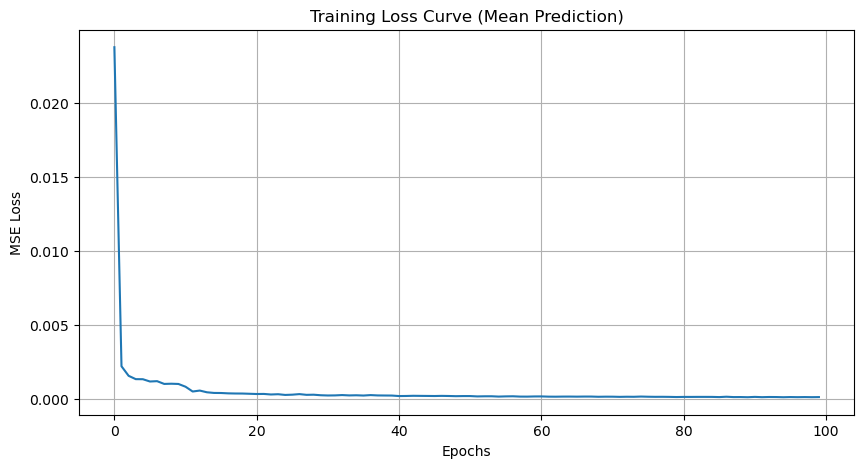

In [5]:
# --- Training Loop ---
print("Training started (Mean Prediction Method)...")
for epoch in range(EPOCHS):
    epoch_loss = 0.0
    for step, (images, _) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")):
        optimizer.zero_grad()

        # 1. Get a batch of clean images x0 and move to device
        x0 = images.to(device)

        # 2. Sample a random timestep t for each image in the batch
        t = torch.randint(0, TIMESTEPS, (BATCH_SIZE,), device=device).long()
        
        # 3. Create noisy images x_t by applying noise
        xt = forward_diffusion_sample(x0, t, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod)

        # 4. **Calculate the true mean of q(x_{t-1} | x_t, x_0)**
        # This will be the target for our neural network.
        mean_target_coef1 = get_index_from_list(posterior_mean_coef1, t, x0.shape)
        mean_target_coef2 = get_index_from_list(posterior_mean_coef2, t, x0.shape)
        mean_target = mean_target_coef1 * x0 + mean_target_coef2 * xt

        # 5. **Predict the mean** using the U-Net model
        predicted_mean = model(xt, t)

        # 6. Calculate the loss between the model's predicted mean and the true mean
        loss = criterion(mean_target, predicted_mean)
        
        # 7. Backpropagate and update weights
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        
    avg_epoch_loss = epoch_loss / len(train_loader)
    loss_history.append(avg_epoch_loss)
    print(f"Epoch {epoch+1} Average Loss: {avg_epoch_loss:.4f}")

print("Training finished.")

# --- Plot Loss Curve ---
plt.figure(figsize=(10, 5))
plt.plot(loss_history)
plt.title("Training Loss Curve (Mean Prediction)")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.show()

Generating images...


Sampling: 100%|██████████| 1000/1000 [00:03<00:00, 331.36it/s]


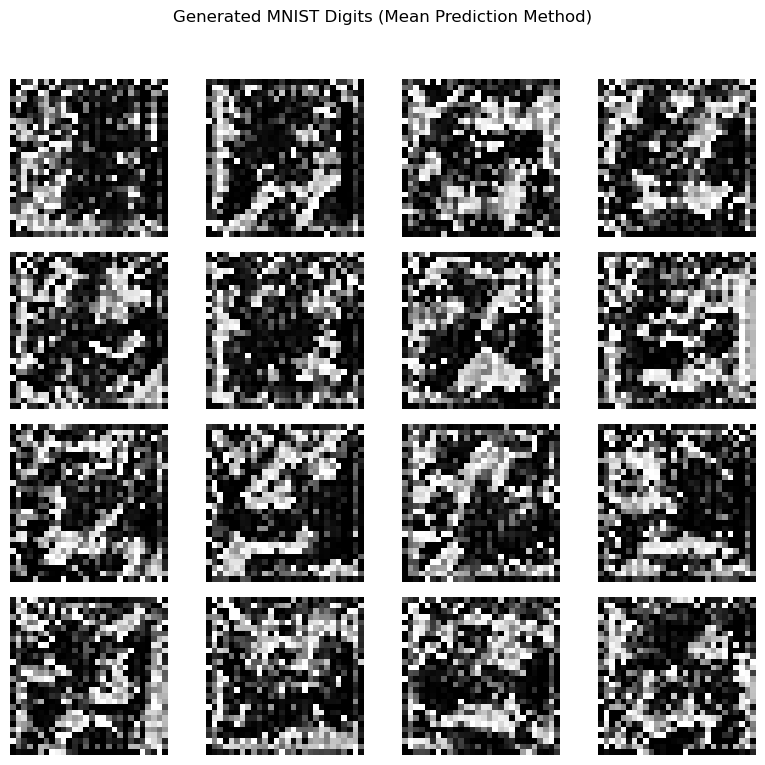

In [6]:
### 4. Image Generation (Sampling) ###
# ------------------------------------
# The sampling process now uses the model's output directly as the mean.

@torch.no_grad()
def sample_timestep(x, t):
    """
    Core sampling function for a single timestep.
    The model directly predicts the mean of p(x_{t-1} | x_t).
    Formula: x_{t-1} = \mu_\theta(x_t, t) + \sqrt{\sigma^2_t} * Z
    """
    # Use the model to predict the mean of the reverse process distribution
    predicted_mean = model(x, t)
    
    # Get the posterior variance
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)
    
    if t.all().item() == 0:
        # For the last step (t=0), there's no noise added
        return predicted_mean
    else:
        # Add noise to the predicted mean
        noise = torch.randn_like(x)
        return predicted_mean + torch.sqrt(posterior_variance_t) * noise

@torch.no_grad()
def generate_images(num_images=16):
    """
    Generates new images by running the full reverse diffusion process.
    """
    print("Generating images...")
    # Start with pure random noise (x_T)
    img = torch.randn((num_images, 1, IMG_SIZE, IMG_SIZE), device=device)
    
    # Loop backwards through the timesteps
    for i in tqdm(reversed(range(0, TIMESTEPS)), desc="Sampling", total=TIMESTEPS):
        t = torch.full((num_images,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
    
    # Un-normalize images from [-1, 1] to [0, 1]
    img = (img + 1) * 0.5
    img = img.clamp(0, 1)
    return img

# --- Generate and Plot Images ---
generated_images = generate_images(num_images=16)

plt.figure(figsize=(8, 8))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(generated_images[i].cpu().squeeze(), cmap='gray')
    plt.axis('off')
plt.suptitle("Generated MNIST Digits (Mean Prediction Method)")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
